# 230968078 - Ishan Suryawanshi - Week 3 - Part A - CIFAR 10 Dataset

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]
class_names

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [ ]:
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Image dimensions:", train_images.shape[1:])

Number of classes: 10
Image dimensions: (32, 32, 3)


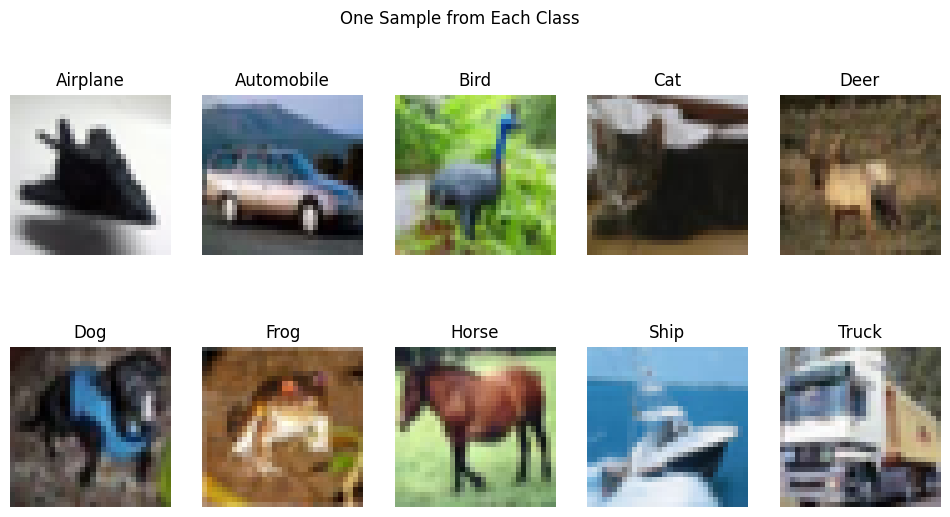

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    # find the first occurrence of class i
    idx = np.where(train_labels == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[idx], cmap="gray")
    plt.title(class_names[i])
    plt.axis("off")
plt.suptitle("One Sample from Each Class")
plt.show()

In [ ]:
# normalizing the images (bring each pixel value from 0-255 to 0-1)
train_images, test_images = train_images / 255.0, test_images / 255.0
# reshaping the input (28 x 28 x 1)
# greyscale images to no rgb layers
train_images = train_images.reshape((train_images.shape[0], 32, 32, 3))
test_images = test_images.reshape((test_labels.shape[0], 32, 32, 3))

In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

### Hyperparameter tuning to find the best model for FCNN

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(32, 32, 3)))
  num_layers = hp.Choice('layers', [1, 2, 3])
  reg_type = hp.Choice('regularization', ['none', 'l1', 'l2'])

  if reg_type == 'l1':
    reg = regularizers.l1(0.01)
  elif reg_type == 'l2':
    reg = regularizers.l2(0.01)
  else:
    reg = None

  model.add(Dense(128, activation='relu', kernel_regularizer=reg))
  if num_layers >= 2:
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
  if num_layers == 3:
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
  model.add(Dense(10, activation='softmax'))

  lr = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
  model.compile(
      optimizer=Adam(lr),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
results = []

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    overwrite=True
)

tuner.search(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]
_, best_val_acc = best_model.evaluate(val_images, val_labels, verbose=0)

results.append({
      "layers": best_hps.get("layers"),
      "regularization": best_hps.get("regularization"),
      "learning_rate": best_hps.get("learning_rate"),
      "val_accuracy": best_val_acc
  })

Trial 5 Complete [00h 01m 11s]
val_accuracy: 0.093299999833107

Best val_accuracy So Far: 0.22669999301433563
Total elapsed time: 00h 05m 42s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
results

[{'layers': 2,
  'regularization': 'l2',
  'learning_rate': 0.01,
  'val_accuracy': 0.22669999301433563}]

In [ ]:
result = results[0]

In [ ]:
def build_best_model(layers, regularization, lr):
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(128, activation="relu"))
    if layers >= 2:
      model.add(Dense(64, activation="relu"))
    if layers == 3:
      model.add(Dense(32, activation="relu"))
    if regularization != "none":
        reg = regularizers.l1(0.01) if regularization == "l1" else regularizers.l2(0.01)
        for layer in model.layers:
            if isinstance(layer, Dense):
                layer.kernel_regularizer = reg

    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
fcnn = build_best_model(
    layers=result["layers"],
    regularization=result["regularization"],
    lr=result["learning_rate"]
)

In [ ]:
fcnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = fcnn.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1008 - loss: 2.8112 - val_accuracy: 0.0979 - val_loss: 2.3052
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.0975 - loss: 2.3044 - val_accuracy: 0.1023 - val_loss: 2.3030
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.0956 - loss: 2.3042 - val_accuracy: 0.0996 - val_loss: 2.3038
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0990 - loss: 2.3039 - val_accuracy: 0.0994 - val_loss: 2.3037
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1003 - loss: 2.3040 - val_accuracy: 0.1030 - val_loss: 2.3033


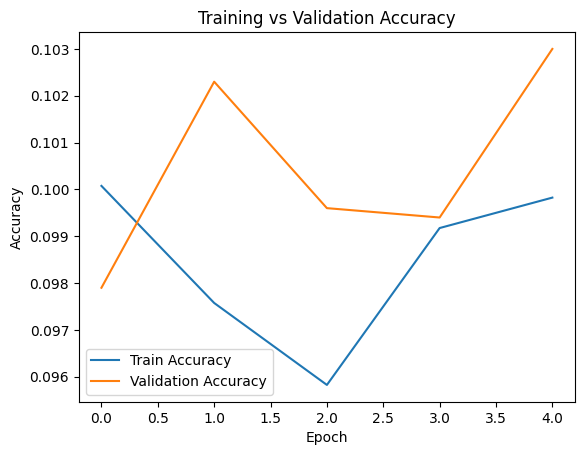

In [ ]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_labels_ = np.argmax(test_labels, axis=1)

In [ ]:
y_pred1 = fcnn.predict(test_images)
y_pred1 = np.argmax(y_pred1, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
test_acc = accuracy_score(test_labels_, y_pred1)

# Calculating precision, recall, and F1-score for multiclass (macro average)
test_prec = precision_score(test_labels_, y_pred1, average='macro', zero_division=1)
test_rec = recall_score(test_labels_, y_pred1, average='macro', zero_division=1)
test_f1 = f1_score(test_labels_, y_pred1, average='macro', zero_division=1)

print("\n===== Test Set Metrics (Multiclass) =====")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-score:  {test_f1:.4f}")


===== Test Set Metrics (Multiclass) =====
Accuracy:  0.1000
Precision: 0.9100
Recall:    0.1000
F1-score:  0.0182


### Training the CNN Model 1

In [ ]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, (5, 5), strides=1, padding='valid', activation='relu', input_shape=(32, 32, 3)))
cnn1.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn1.add(Flatten())
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn1.compile(
    optimizer=Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,742 (2.41 MB)

 Trainable params: 630,742 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = cnn1.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.0966 - loss: 2.3416 - val_accuracy: 0.0979 - val_loss: 2.3051
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.0985 - loss: 2.3042 - val_accuracy: 0.1030 - val_loss: 2.3051
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.0995 - loss: 2.3049 - val_accuracy: 0.0933 - val_loss: 2.3043
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.0984 - loss: 2.3040 - val_accuracy: 0.0933 - val_loss: 2.3041
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.0990 - loss: 2.3039 - val_accuracy: 0.0996 - val_loss: 2.3040
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.0988 - loss: 2.3040 - val_accuracy: 0.1023 - val_loss: 2.3029
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.0995 - loss: 2.3039 - val_accuracy: 0.1030 - val_loss: 2.3040
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.1008 -

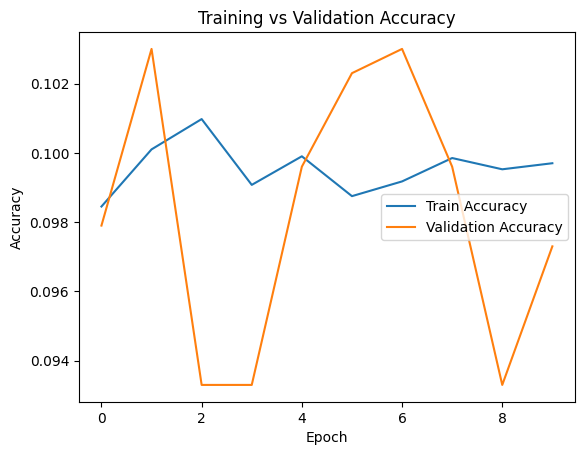

In [ ]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss1, test_acc1 = cnn1.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_acc1:.4f}")
print(f"Test Loss: {test_loss1:.4f}")

313/313 - 3s - 9ms/step - accuracy: 0.1000 - loss: 2.3032

Test Accuracy: 0.1000
Test Loss: 2.3032


### Training CNN Model 2

In [ ]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=(32, 32, 3)))
cnn2.add(Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), strides=2))
cnn2.add(Flatten())
cnn2.add(Dense(100, activation='relu'))
cnn2.add(Dense(10, activation='softmax'))

In [ ]:
cnn2.compile(
    optimizer=Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       627,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638,454 (2.44 MB)

 Trainable params: 638,454 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = cnn2.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 69ms/step - accuracy: 0.0998 - loss: 2.4279 - val_accuracy: 0.0973 - val_loss: 2.3040
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.0996 - loss: 2.3042 - val_accuracy: 0.0994 - val_loss: 2.3034
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 71ms/step - accuracy: 0.1003 - loss: 2.3039 - val_accuracy: 0.0979 - val_loss: 2.3042
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step - accuracy: 0.0986 - loss: 2.3045 - val_accuracy: 0.0933 - val_loss: 2.3056
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 67ms/step - accuracy: 0.1011 - loss: 2.3037 - val_accuracy: 0.1015 - val_loss: 2.3043
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 71ms/step - accuracy: 0.1016 - loss: 2.3040 - val_accuracy: 0.0979 - val_loss: 2.3055
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 67ms/step - accuracy: 0.1009 - loss: 2.3041 - val_accuracy: 0.1040 - val_loss: 2.3027
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 71ms/step - accuracy: 0.

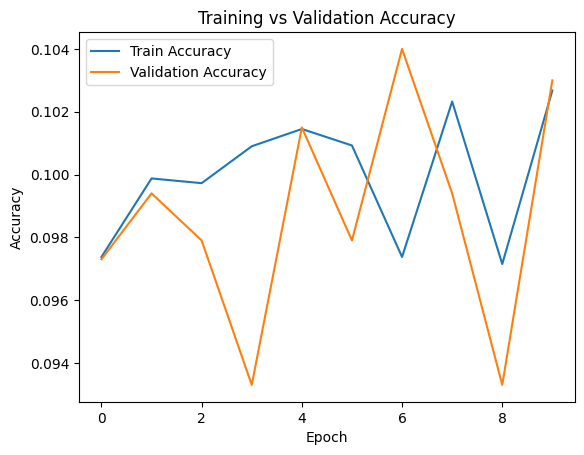

In [ ]:
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss2, test_acc2 = cnn2.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest Accuracy: {test_acc2:.4f}")
print(f"Test Loss: {test_loss2:.4f}")

313/313 - 5s - 15ms/step - accuracy: 0.1000 - loss: 2.3033

Test Accuracy: 0.1000
Test Loss: 2.3033


## Comparing the accuracy of all the three models

We can see the three models perform roughly the same, with the second CNN network performing slightly better.

Total Parameters for all the models: <br />
Fully Connected Neural network: 402250<br />
CNN Architecture 1: 630742 <br />
CNN Architecture 2: 638454 <br />

We can see that CNNs have much more parameters to train. Most of the parameters for the Convolutional neural networks come from the dense layer.
